# enrichment comparisons

## enrichment

Overall, want to see what motifs are enriched by combining shap contribution and ISM approahces (union). Then, want to compare what is enriched in one grouping relative to a background one

In [1]:
import evalism_v22 as evalism
from seq2atac.stable import read_pickle

/home/akumar22/anaconda3/envs/python38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
from scipy import stats
import time
import sys
# from reg_diffs.scripts import evalism_v22 as evalism 
import glob
import pickle

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

import re
import pybedtools
import scipy

from sklearn.linear_model import LinearRegression
# from adjustText import adjust_text
from scipy.stats import spearmanr

# import scanpy as sc

In [3]:
# change merging fx
def merge_shap_ism(
    sample: str = 'brca',
    file_pattern: str = '/illumina/scratch/deep_learning/akumar22/TCGA/peak_shap/{}',
    out_pattern: str or None = '/illumina/scratch/deep_learning/nravindra/tmp/tcga/motif_analysis/union_shap_ism_{}_v2.csv',
    name_key: str = 'group_name',
    modify_names: dict or None = None,
    return_only_cleaned: bool = True,
    verbose: bool = True,
):
    """Identify significant motifs in a sample
    
    Arguments: 
      modif_names: dict or None (optional, default: None)
        Modify the motif name with broader name sets by providing a dict
        key that will alter tha name_key to a new column `modified_names`, 
        then use that column to count things
    """
    if verbose:
        tic = time.time()
        print('\nMerging SHAP/ISM for {}'.format(sample))
        
    shap_cleaned = os.path.join(file_pattern.format(sample.upper()), 'motifs_cleaned.csv')
    shap_all = os.path.join(file_pattern.format(sample.upper()), 'motifs_with_contribution_scores.csv')
    assert os.path.exists(file_pattern.format(sample.upper())), 'where are the shap peaks?'
    assert os.path.exists(shap_cleaned), 'need cleaned motifs'
    assert os.path.exists(shap_all), 'need uncleaned motifs'
    
    shap_cleaned = pd.read_csv(shap_cleaned, index_col=0)
    shap_all = pd.read_csv(shap_all, index_col=0)
    
    shap_cleaned['enrichment_shap'] = True
    shap_df = shap_all.merge(shap_cleaned, on=['group_name', 'seqnames', 'start', 'end'], how='left', suffixes=['', '_cleaned'])
    shap_df['enrichment_shap'].fillna(False, inplace=True)
    del shap_cleaned, shap_all
    
    if modify_names is not None:
        shap_df['modified_names'] = shap_df[name_key].map(modify_names)
    
    ism_df = evalism.cleaning(sample, apply_filter=False)
    if modify_names is not None:
        ism_df['modified_names'] = ism_df[name_key].map(modify_names)
    
    if modify_names is not None:
        name_key = 'modified_names'
    ism_coi = [name_key, 'seqnames', 'start', 'end', 'es', 'enrichment', ]
    shap_coi = [name_key, 'seqnames', 'start', 'end', 'contribution', 'enrichment_shap', ]

    dt = ism_df[ism_coi].merge(shap_df[shap_coi], on=[name_key, 'seqnames', 'start', 'end'], how='outer')
    
    # add count before
    dt = dt.merge(dt.groupby(name_key).count()['end'], how='left', left_on=name_key, right_index=True, suffixes=['', '_cnt_before'])

    # add count after
    dt = dt.merge(dt.loc[(dt['enrichment_shap']) | (dt['enrichment']=='cleaned')].groupby(name_key).count()['end'], how='left', left_on=name_key, right_index=True, suffixes=['', '_cnt_after'])
    
    if verbose:
        print('  ... done after {:.1f}-s'.format(time.time() - tic))
        
    # return only cleaned?
    if return_only_cleaned:
        dt = dt.loc[(dt['enrichment_shap']) | (dt['enrichment']=='cleaned')]
        
    return dt
    
    
def merge_shap_ism_samples(
    samples: list = ['brca', 'blca', 'luad', 'kirp', 'kirc', 'skcm', 'gbm', 'coad', ],
    modify_names: dict or None = None,
    file_pattern: str = '/illumina/scratch/deep_learning/akumar22/TCGA/peak_shap/{}',
    verbose: bool = True,
    outfile: str or None = None,
):
    """Identify significant motifs in a sample
    
    Arguments: 
      modif_names: dict or None (optional, default: None)
        Modify the motif name with broader name sets by providing a dict
        key that will alter tha name_key to a new column `modified_names`, 
        then use that column to count things
    """
    if outfile is not None:
        if not os.path.exists(os.path.split(outfile)[0]):
            os.makedirs(os.path.split(outfile)[0])
    if verbose:
        tic = time.time()
        print('Merging samples:', samples)
    out = {}
    for s in samples:
        out[s] = merge_shap_ism(sample=s, file_pattern=file_pattern, modify_names=modify_names)
        if verbose:
            print('  through {}\telapsed: {:.1f}-s'.format(s, time.time() - tic))
    if outfile is not None:
        with open(outfile, 'wb') as f:
            pickle.dump(out, f, protocol=pickle.HIGHEST_PROTOCOL)
            f.close()
    return out

def viz_compare_enrich(
    df: pd.DataFrame,
    sample_key: str = 'sample',
    name_key: str = 'group_name',
    drop_duplicates_key: str or None = 'group_name',
    topn: int or None = 10,
    fillna: bool = False,
    names2display: dict or None = None,
    viz_OR: bool = True,
    drop: str = None,
    zscore: str or None = None,
    save_plot: str or None = None,
    save_mat: str or None = None,
    return_plot_obj: bool = False,
):
    """Visualize the top motifs in each sample in a heatmap
    
    Arguments:
      name_key
        will be used to index the visuzliation
      names2display: dict or None (optional, Default: None)
        send a dict to map the sample key to a new naming scheme for display
      drop: str or None (optional, default: None)
        ignore anything with this string pattern in the names
      zscore: str (optional, default: None)
        option to zscore 'row', 'col', or 'row' first, then 'col', i.e., 'rowcol'
    """
    
    agg = pd.DataFrame()
    valid_names = []
    for s in np.sort(df[sample_key].unique()):
        dt = df.loc[df[sample_key]==s, :]
        if drop is not None:
            dt = dt.loc[[False if drop in n else True for n in dt[name_key]], :]
        dt = dt.sort_values(by=['p_bonferonni', 'OR'], ascending=[True, False])
        if drop_duplicates_key is not None:
            dt = dt.drop_duplicates(subset=drop_duplicates_key)
        if topn is not None:
            dt = dt.iloc[:topn, :] 
        if not fillna:
            valid_names += dt[name_key].unique().tolist()
        else:
            agg = pd.concat([agg, dt], ignore_index=True)
    if not fillna:
        valid_names = list(np.unique(valid_names))
        for s in np.sort(df[sample_key].unique()):
            dt = df.loc[df[sample_key]==s, :]
            dt = dt.sort_values(by=['p_bonferonni', 'OR'], ascending=[True, False])
            if drop_duplicates_key is not None:
                dt = dt.drop_duplicates(subset=drop_duplicates_key)
            dt = dt.loc[[True if i in valid_names else False for i in dt[name_key]], :]
            agg = pd.concat([agg, dt], ignore_index=True)
    
    
    if names2display is not None:
        agg['sample2'] = agg[sample_key].map(names2display)
        sample_key = 'sample2'   
    if False:
        dtt = agg.loc[[False if i.split('|')[1].startswith('Z') else True for i in agg[name_key]], :] # modify group_name
    else:
        dtt = agg
    if viz_OR:
        if False:
            # log2( OR )
            dt = (np.log2(pd.pivot(dtt, index=name_key, columns=sample_key)['OR']))
        else:
            # not transformed OR
            dt = (pd.pivot(dtt, index=name_key, columns=sample_key)['OR'])
    else:
        dt = (-1*np.log10(pd.pivot(dtt, index=name_key, columns=sample_key)['p_bonferonni']))
    if fillna:
        dt.fillna(0, inplace=True)
    dt.replace([np.inf], 300, inplace=True)
    
    dtt = dt.copy()
    if zscore is None:
        p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap='hot_r', row_cluster=True, col_cluster=True)
    elif zscore == 'col':
        p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap='hot_r', row_cluster=True, col_cluster=True, z_score=1)
    elif zscore == 'row':
        p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap='hot_r', row_cluster=True, col_cluster=True, z_score=0)
    elif zscore == 'rowcol':
        from scipy.stats import zscore
        dt = zscore(dt, axis=1)
        p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap='hot_r', row_cluster=True, z_score=1)
    if save_plot is not None:
        p.savefig(save_plot)
    if save_mat is not None:
        p.data2d.to_csv(save_mat)
    if return_plot_obj:
        return agg, p, {'df_plot': dt, 'df_prez': dtt}
    else:
        return agg

In [4]:
def viz_compare_enrich(
    df: pd.DataFrame,
    sample_key: str = 'sample',
    name_key: str = 'group_name',
    drop_duplicates_key: str or None = 'group_name',
    topn: int or None = 10,
    fillna: bool = False,
    names2display: dict or None = None,
    viz_OR: bool = True,
    drop: str = None,
    zscore: str or None = None,
    save_plot: str or None = None,
    save_mat: str or None = None,
    return_plot_obj: bool = False,
):
    """Visualize the top motifs in each sample in a heatmap
    
    Arguments:
      name_key
        will be used to index the visuzliation
      names2display: dict or None (optional, Default: None)
        send a dict to map the sample key to a new naming scheme for display
      drop: str or None (optional, default: None)
        ignore anything with this string pattern in the names
      zscore: str (optional, default: None)
        option to zscore 'row', 'col', or 'row' first, then 'col', i.e., 'rowcol'
    """
    
    agg = pd.DataFrame()
    valid_names = []
    for s in np.sort(df[sample_key].unique()):
        dt = df.loc[df[sample_key]==s, :]
        if drop is not None:
            dt = dt.loc[[False if drop in n else True for n in dt[name_key]], :]
        dt = dt.sort_values(by=['p_bonferonni', 'OR'], ascending=[True, False])
        if drop_duplicates_key is not None:
            dt = dt.drop_duplicates(subset=drop_duplicates_key)
        if topn is not None:
            dt = dt.iloc[:topn, :] 
        if not fillna:
            valid_names += dt[name_key].unique().tolist()
        else:
            agg = pd.concat([agg, dt], ignore_index=True)
    if not fillna:
        valid_names = list(np.unique(valid_names))
        for s in np.sort(df[sample_key].unique()):
            dt = df.loc[df[sample_key]==s, :]
            dt = dt.sort_values(by=['p_bonferonni', 'OR'], ascending=[True, False])
            if drop_duplicates_key is not None:
                dt = dt.drop_duplicates(subset=drop_duplicates_key)
            dt = dt.loc[[True if i in valid_names else False for i in dt[name_key]], :]
            agg = pd.concat([agg, dt], ignore_index=True)
    
    
    if names2display is not None:
        agg['sample2'] = agg[sample_key].map(names2display)
        sample_key = 'sample2'   
    if False:
        dtt = agg.loc[[False if i.split('|')[1].startswith('Z') else True for i in agg[name_key]], :] # modify group_name
    else:
        dtt = agg
    if viz_OR:
        if False:
            # log2( OR )
            dt = (np.log2(pd.pivot(dtt, index=name_key, columns=sample_key)['OR']))
        else:
            # not transformed OR
            dt = (pd.pivot(dtt, index=name_key, columns=sample_key)['OR'])
    else:
        dt = (-1*np.log10(pd.pivot(dtt, index=name_key, columns=sample_key)['p_bonferonni']))
    if fillna:
        dt.fillna(0, inplace=True)
    dt.replace([np.inf], 300, inplace=True)
    
    dtt = dt.copy()
    if zscore is None:
        p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap='hot_r', row_cluster=True, col_cluster=True)
    elif zscore == 'col':
        p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap='hot_r', row_cluster=True, col_cluster=True, z_score=1)
    elif zscore == 'row':
        p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap='hot_r', row_cluster=True, col_cluster=True, z_score=0)
    elif zscore == 'rowcol':
        from scipy.stats import zscore
        dt = zscore(dt, axis=1)
        p = sns.clustermap(dt, xticklabels=True, yticklabels=True, cmap='hot_r', row_cluster=True, z_score=1)
    if save_plot is not None:
        p.savefig(save_plot)
    if save_mat is not None:
        p.data2d.to_csv(save_mat)
    if return_plot_obj:
        return agg, p, {'df_plot': dt, 'df_prez': dtt}
    else:
        return agg

## per individual sample

### group conditioning vs. not

each sample may have a group where non-group memebers ONLY can be considered as the background

In [5]:
# specify groups

groups = {'luminal': ['brca{}'.format(n) for n in ['10', '12', '15', '20', '22', ]],
          'basal': ['brca{}'.format(n) for n in ['14', '16', '23', '24', '25', ]],
          'her2': ['brca{}'.format(n) for n in ['11', '13', '17', '18', '19', '21', ]]}

sample2grp = {}
for k, v in groups.items():
    for s in v:
        sample2grp[s] = '{}.{}'.format(k, s.split('brca')[-1])
sample2grp

{'brca10': 'luminal.10',
 'brca12': 'luminal.12',
 'brca15': 'luminal.15',
 'brca20': 'luminal.20',
 'brca22': 'luminal.22',
 'brca14': 'basal.14',
 'brca16': 'basal.16',
 'brca23': 'basal.23',
 'brca24': 'basal.24',
 'brca25': 'basal.25',
 'brca11': 'her2.11',
 'brca13': 'her2.13',
 'brca17': 'her2.17',
 'brca18': 'her2.18',
 'brca19': 'her2.19',
 'brca21': 'her2.21'}

In [6]:
### create an identity mapping from vierstra archetype to itself
vierstra_names = read_pickle("../vierstra_individual_name_to_group_name_map.pkl").values()
name_keys = dict(zip(vierstra_names,vierstra_names))
name_keys

{'AP1/2': 'AP1/2',
 'KLF/SP/2': 'KLF/SP/2',
 'ZNF449': 'ZNF449',
 'HD/8': 'HD/8',
 'HD/2': 'HD/2',
 'HD/23': 'HD/23',
 'FOX/1': 'FOX/1',
 'NR/3': 'NR/3',
 'Ebox/CAGATGG': 'Ebox/CAGATGG',
 'ZNF768': 'ZNF768',
 'ZNF324': 'ZNF324',
 'Ebox/CACCTG': 'Ebox/CACCTG',
 'Ebox/CAGCTG': 'Ebox/CAGCTG',
 'ZSCAN3': 'ZSCAN3',
 'E2F/2': 'E2F/2',
 'KLF/SP/1': 'KLF/SP/1',
 'PRDM5': 'PRDM5',
 'THAP1': 'THAP1',
 'ZNF667': 'ZNF667',
 'RUNX/1': 'RUNX/1',
 'ZIC': 'ZIC',
 'PRDM16': 'PRDM16',
 'FOX/8': 'FOX/8',
 'TEAD': 'TEAD',
 'HD/11': 'HD/11',
 'NR/11': 'NR/11',
 'SMARCA5': 'SMARCA5',
 'PAX/1': 'PAX/1',
 'TATA': 'TATA',
 'NR/16': 'NR/16',
 'ZNF554': 'ZNF554',
 'FOX/5': 'FOX/5',
 'FOX/4': 'FOX/4',
 'AP1/1': 'AP1/1',
 'NR/19': 'NR/19',
 'ETS/2': 'ETS/2',
 'SIX/1': 'SIX/1',
 'GLI': 'GLI',
 'ZSCAN4': 'ZSCAN4',
 'KLF/SP/3': 'KLF/SP/3',
 'ZNF85': 'ZNF85',
 'Ebox/CACGTG/1': 'Ebox/CACGTG/1',
 'Ebox/CACGTG/2': 'Ebox/CACGTG/2',
 'HIC/1': 'HIC/1',
 'ZNF143': 'ZNF143',
 'TBX/3': 'TBX/3',
 'POU/2': 'POU/2',
 'POU/3': 'PO

In [5]:
## 1. count motifs
enrich_df = merge_shap_ism_samples(
    samples=['brca{}'.format(i) for i in range(10, 26)],
    modify_names=name_keys,
    file_pattern='/illumina/scratch/deep_learning/akumar22/TCGA/peak_shap/brca_samples/{}',
    outfile = "/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/cleaned_instances_brca.pkl")

Merging samples: ['brca10', 'brca11', 'brca12', 'brca13', 'brca14', 'brca15', 'brca16', 'brca17', 'brca18', 'brca19', 'brca20', 'brca21', 'brca22', 'brca23', 'brca24', 'brca25']

Merging SHAP/ISM for brca10

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/brca10_v12.pkl
  ... done after 119.5-s
  through brca10	elapsed: 124.5-s

Merging SHAP/ISM for brca11

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/brca11_v12.pkl
  ... done after 87.3-s
  through brca11	elapsed: 215.5-s

Merging SHAP/ISM for brca12

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/brca12_v12.pkl
  ... done after 102.1-s
  through brca12	elapsed: 321.9-s

Merging SHAP/ISM for brca13

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/brca13_v12.pkl
  ... done after 104.7-s
  through brca13	elapsed: 430.8-s

Merging SHAP/ISM for brca14

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/brca14_v12.pkl
  ... done after 96.1-s
  throug

In [7]:
enrich_df = read_pickle("/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/cleaned_instances_brca.pkl")
### load these motifs

In [8]:
## 2. enrichment test
enrich_out = evalism.chi2ovr(
    data=enrich_df,
    groups=None,
    notB_key='end_cnt_before', 
    B_key='end_cnt_after',
    return_df=True,
    verbose=True,
    name_key='modified_names',
    )
print('pct significant: {:.2f}'.format(100*(enrich_out['p_bonferonni'] < 0.5).sum()/enrich_out.shape[0]))
enrich_out.to_csv('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/motifenrichment_indbrcaVrest_ism_shap_overlap_simplenames.csv')

data merged into one df in 23-s
through brca10. time elapsed: 24-s
through brca11. time elapsed: 24-s
through brca12. time elapsed: 24-s
through brca13. time elapsed: 24-s
through brca14. time elapsed: 24-s
through brca15. time elapsed: 24-s
through brca16. time elapsed: 24-s
through brca17. time elapsed: 24-s
through brca18. time elapsed: 24-s
through brca19. time elapsed: 24-s
through brca20. time elapsed: 24-s
through brca21. time elapsed: 24-s
through brca22. time elapsed: 24-s
through brca23. time elapsed: 24-s
through brca24. time elapsed: 25-s
through brca25. time elapsed: 25-s
n_tst: 4512
pct significant: 66.40


In [ ]:
enrich_out = pd.read_csv('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/motifenrichment_indbrcaVrest_ism_shap_overlap_simplenames.csv')


,modified_names,p_chi2,OR,sample,p_bonferonni,sample2
0,FOX/4,0.000000e+00,1.286587,brca10,0.000000e+00,luminal.10
1,FOX/5,0.000000e+00,1.281843,brca10,0.000000e+00,luminal.10
2,GC-tract,0.000000e+00,0.926368,brca10,0.000000e+00,luminal.10
3,CCAAT/CEBP,0.000000e+00,0.506255,brca10,0.000000e+00,luminal.10
4,KLF/SP/2,1.050775e-311,0.938397,brca10,4.741096e-308,luminal.10
...,...,...,...,...,...,...
811,CREB/ATF/1,5.841132e-06,1.047281,brca25,2.635519e-02,basal.25
812,SMAD,5.937564e-06,0.976011,brca25,2.679029e-02,basal.25
813,ETS/1,1.391125e-03,0.981970,brca25,6.276755e+00,basal.25
814,IRF/1,1.058550e-01,1.018667,brca25,4.776176e+02,basal.25


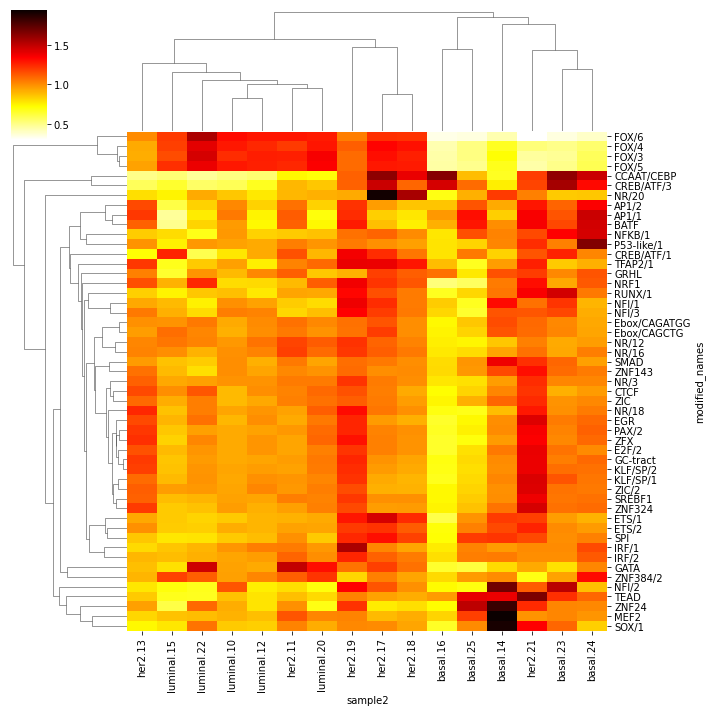

In [9]:
## 3. visualize
agg = viz_compare_enrich(enrich_out, name_key='modified_names', drop_duplicates_key='modified_names', names2display=sample2grp)
agg

0 rowcol_20_ZNF
  wrote /illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/clustermap_cmpmotifenrich_indbrca_zrowcol_top20_dropZNF_preZ_v12.csv
  wrote /illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/clustermap_cmpmotifenrich_indbrca_zrowcol_top20_dropZNF_postZ_v12.csv


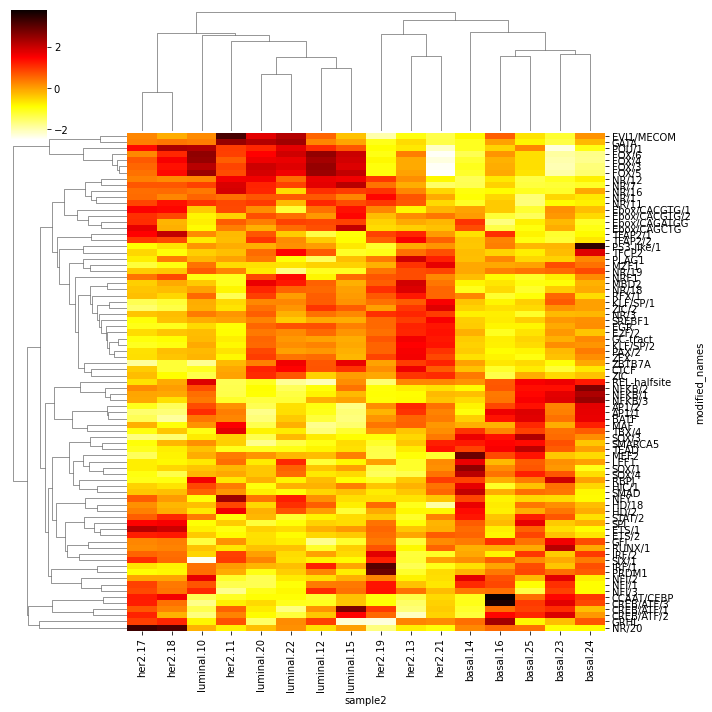

In [10]:
# grid ={'zscore': ['rowcol',],
#        'topn': [20, None],
#        'drop': ['ZNF', None]}
grid ={'zscore': ['rowcol',],
       'topn': [20],
       'drop': ['ZNF']}
count = 0
for zscore_type in grid['zscore']:
    for n in grid['topn']:
        for drop_motif in grid['drop']:
            print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
            agg, p, dt = viz_compare_enrich(
                enrich_out, 
                name_key='modified_names', 
                drop_duplicates_key='modified_names', 
                names2display=sample2grp,
                topn=n,
                drop=drop_motif,
                zscore=zscore_type,
                save_plot=None,# if not export else './figures/clustermap_cmpmotifenrich_indbrca_z{}_top{}_drop{}.pdf'.format(zscore_type, n, drop_motif),
                save_mat=None,# if not export else '/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clustermap_cmpmotifenrich_indbrca_z{}_top{}_drop{}.csv'.format(zscore_type, n, drop_motif),
                return_plot_obj=True,
            )
            dt['df_prez'].to_csv('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/clustermap_cmpmotifenrich_indbrca_z{}_top{}_drop{}_preZ_v12.csv'.format(zscore_type, n, drop_motif))
            print('  wrote {}'.format('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/clustermap_cmpmotifenrich_indbrca_z{}_top{}_drop{}_preZ_v12.csv'.format(zscore_type, n, drop_motif)))
            dt["df_plot"].to_csv('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/clustermap_cmpmotifenrich_indbrca_z{}_top{}_drop{}_postZ_v12.csv'.format(zscore_type, n, drop_motif))
            print('  wrote {}'.format('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/brca_sample_expt/clustermap_cmpmotifenrich_indbrca_z{}_top{}_drop{}_postZ_v12.csv'.format(zscore_type, n, drop_motif)))

            count+=1

In [25]:
print(p.dendrogram_row.reordered_ind)
print(p.dendrogram_col.reordered_ind)
print(dt["df_plot"].index[p.dendrogram_row.reordered_ind])
print(dt["df_plot"].columns[p.dendrogram_col.reordered_ind])

[53, 48, 55, 52, 49, 50, 51, 29, 47, 58, 24, 59, 77, 82, 0, 1, 4, 40, 7, 60, 78, 79, 65, 12, 13, 22, 69, 16, 61, 41, 43, 54, 68, 70, 45, 44, 46, 34, 66, 64, 62, 63, 42, 56, 14, 15, 11, 33, 2, 32, 30, 31, 5, 81, 8, 21, 38, 6, 37, 67, 83, 35, 10, 9, 71, 75, 73, 74, 20, 76, 26, 25, 27, 3, 28, 36, 39, 72, 57, 80, 23, 19, 17, 18]
[2, 0, 6, 4, 5, 3, 1, 7]
Index(['NR/2', 'NR/1', 'NR/3', 'NR/16', 'NR/11', 'NR/12', 'NR/13', 'HD/2',
       'NFKB/1', 'PAX/1', 'HD/10', 'PAX/2', 'TEAD', 'ZIC', 'AP1/1', 'AP1/2',
       'CREB/ATF/1', 'MAF', 'EBF1', 'PRDM16', 'TFAP2/1', 'TFAP2/2', 'RUNX/1',
       'Ebox/CACGTG/1', 'Ebox/CACGTG/2', 'GFI', 'SOX/3', 'Ebox/CATATG', 'RBPJ',
       'MEF2', 'NFAT/2', 'NR/20', 'SOX/1', 'SOX/4', 'NFI/2', 'NFI/1', 'NFI/3',
       'HIC/1', 'SMAD', 'RFX/3', 'RFX/1', 'RFX/2', 'MYB/5', 'OSR2',
       'Ebox/CAGATGG', 'Ebox/CAGCTG', 'Ebox/CACCTG', 'HEN1', 'CCAAT/CEBP',
       'HD/4', 'HD/21', 'HD/22', 'CTCF', 'ZFX', 'EGR', 'GC-tract', 'KLF/SP/2',
       'E2F/2', 'KLF/SP/1', 'SNAI2', 

# cancer samples

In [15]:
## 1. count motifs
enrich_df = merge_shap_ism_samples(
    samples=['brca', 'gbm', 'coad', 'luad', 'skcm', 'kirp', 'kirc', 'blca', ],
    modify_names=name_keys,
    file_pattern='/illumina/scratch/deep_learning/akumar22/TCGA/peak_shap/{}',
    outfile = "/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/cancer_sample_expt/cleaned_instances_cancer.pkl")

Merging samples: ['brca', 'gbm', 'coad', 'luad', 'skcm', 'kirp', 'kirc', 'blca']

Merging SHAP/ISM for brca

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/brca_v12.pkl
  ... done after 529.4-s
  through brca	elapsed: 550.9-s

Merging SHAP/ISM for gbm

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/gbm_v12.pkl
  ... done after 271.9-s
  through gbm	elapsed: 834.4-s

Merging SHAP/ISM for coad

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/coad_v12.pkl
  ... done after 303.7-s
  through coad	elapsed: 1151.0-s

Merging SHAP/ISM for luad

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/luad_v12.pkl
  ... done after 292.0-s
  through luad	elapsed: 1455.5-s

Merging SHAP/ISM for skcm

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/skcm_v12.pkl
  ... done after 292.1-s
  through skcm	elapsed: 1759.5-s

Merging SHAP/ISM for kirp

  ism file: /illumina/scratch/deep_learning/nravindra/tmp/results/kirp_

In [16]:
## 2. enrichment test
enrich_out = evalism.chi2ovr(
    data=enrich_df,
    groups=None,
    notB_key='end_cnt_before', 
    B_key='end_cnt_after',
    return_df=True,
    verbose=True,
    name_key='modified_names',
    )
print('pct significant: {:.2f}'.format(100*(enrich_out['p_bonferonni'] < 0.5).sum()/enrich_out.shape[0]))
enrich_out.to_csv('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/cancer_sample_expt/motifenrichment_canceriVrest_ism_shap_overlap_simplenames.csv')
        

data merged into one df in 32-s
through brca. time elapsed: 32-s
through gbm. time elapsed: 32-s
through coad. time elapsed: 32-s
through luad. time elapsed: 32-s
through skcm. time elapsed: 32-s
through kirp. time elapsed: 32-s
through kirc. time elapsed: 32-s
through blca. time elapsed: 32-s
n_tst: 2256
pct significant: 79.83


,modified_names,p_chi2,OR,sample,p_bonferonni
0,P53-like/1,0.000000e+00,1.691950,blca,0.000000
1,GRHL,0.000000e+00,1.683910,blca,0.000000
2,TFCP2,0.000000e+00,1.375563,blca,0.000000
3,ETS/1,0.000000e+00,1.260021,blca,0.000000
4,SPI,0.000000e+00,1.231284,blca,0.000000
...,...,...,...,...,...
459,HD/17,1.101986e-07,0.939755,skcm,0.000249
460,HD/18,1.452420e-07,0.973936,skcm,0.000328
461,MAF,1.873430e-02,1.010803,skcm,42.264591
462,TEAD,9.746056e-02,0.990847,skcm,219.871023


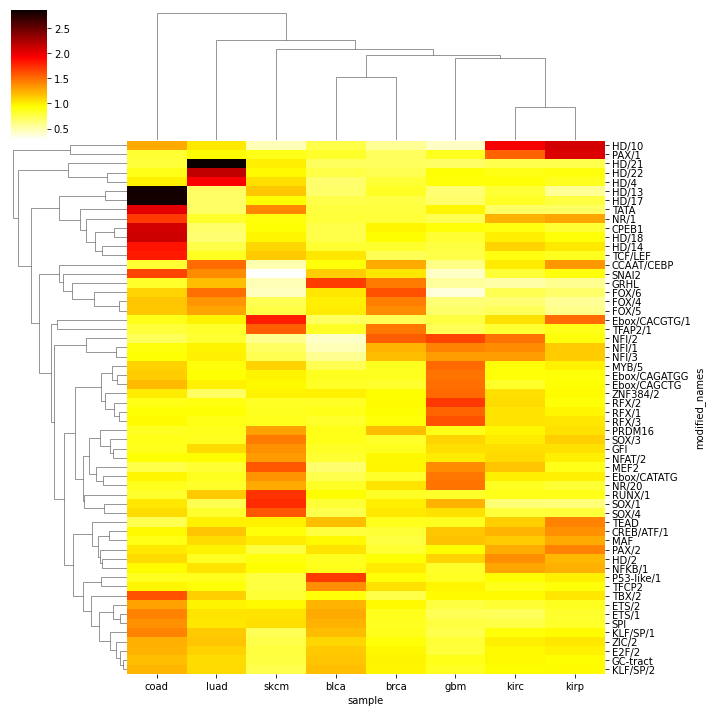

In [17]:
## 3. visualize
agg = viz_compare_enrich(enrich_out, name_key='modified_names', drop_duplicates_key='modified_names')
agg

0 rowcol_20_ZNF
  wrote /illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/cancer_sample_expt/clustermap_cmpmotifenrich_cancer_zrowcol_top20_dropZNF_preZ_v12.csv
  wrote /illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/cancer_sample_expt/clustermap_cmpmotifenrich_cancer_zrowcol_top20_dropZNF_postZ_v12.csv


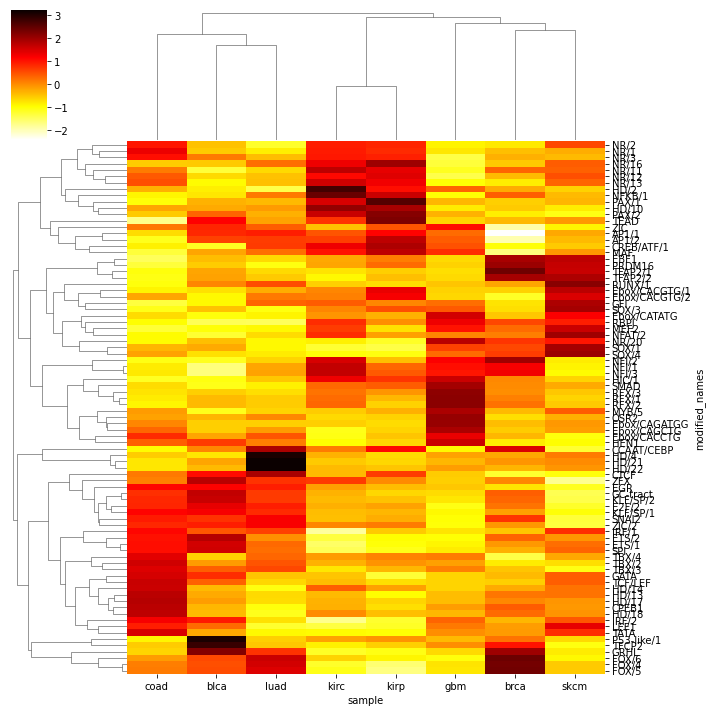

In [21]:
# grid ={'zscore': ['rowcol',],
#        'topn': [20, None],
#        'drop': ['ZNF', None]}
grid ={'zscore': ['rowcol',],
       'topn': [20],
       'drop': ['ZNF']}
count = 0
for zscore_type in grid['zscore']:
    for n in grid['topn']:
        for drop_motif in grid['drop']:
            print(count, '{}_{}_{}'.format(zscore_type, n, drop_motif))
            agg, p, dt = viz_compare_enrich(
                enrich_out, 
                name_key='modified_names', 
                drop_duplicates_key='modified_names', 
                names2display=None,
                topn=n,
                drop=drop_motif,
                zscore=zscore_type,
                save_plot=None,# if not export else './figures/clustermap_cmpmotifenrich_indbrca_z{}_top{}_drop{}.pdf'.format(zscore_type, n, drop_motif),
                save_mat=None,# if not export else '/illumina/scratch/deep_learning/nravindra/tmp/results/reg_diffs/clustermap_cmpmotifenrich_indbrca_z{}_top{}_drop{}.csv'.format(zscore_type, n, drop_motif),
                return_plot_obj=True,
            )
            dt['df_prez'].to_csv('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/cancer_sample_expt/clustermap_cmpmotifenrich_cancer_z{}_top{}_drop{}_preZ_v12.csv'.format(zscore_type, n, drop_motif))
            print('  wrote {}'.format('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/cancer_sample_expt/clustermap_cmpmotifenrich_cancer_z{}_top{}_drop{}_preZ_v12.csv'.format(zscore_type, n, drop_motif)))
            dt["df_plot"].to_csv('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/cancer_sample_expt/clustermap_cmpmotifenrich_cancer_z{}_top{}_drop{}_postZ_v12.csv'.format(zscore_type, n, drop_motif))
            print('  wrote {}'.format('/illumina/scratch/deep_learning/akumar22/TCGA/motif_enrichment_fig2/cancer_sample_expt/clustermap_cmpmotifenrich_cancer_z{}_top{}_drop{}_postZ_v12.csv'.format(zscore_type, n, drop_motif)))

            count+=1

In [26]:
print(p.dendrogram_row.reordered_ind)
print(p.dendrogram_col.reordered_ind)
print(dt["df_plot"].index[p.dendrogram_row.reordered_ind])
print(dt["df_plot"].columns[p.dendrogram_col.reordered_ind])

[53, 48, 55, 52, 49, 50, 51, 29, 47, 58, 24, 59, 77, 82, 0, 1, 4, 40, 7, 60, 78, 79, 65, 12, 13, 22, 69, 16, 61, 41, 43, 54, 68, 70, 45, 44, 46, 34, 66, 64, 62, 63, 42, 56, 14, 15, 11, 33, 2, 32, 30, 31, 5, 81, 8, 21, 38, 6, 37, 67, 83, 35, 10, 9, 71, 75, 73, 74, 20, 76, 26, 25, 27, 3, 28, 36, 39, 72, 57, 80, 23, 19, 17, 18]
[2, 0, 6, 4, 5, 3, 1, 7]
Index(['NR/2', 'NR/1', 'NR/3', 'NR/16', 'NR/11', 'NR/12', 'NR/13', 'HD/2',
       'NFKB/1', 'PAX/1', 'HD/10', 'PAX/2', 'TEAD', 'ZIC', 'AP1/1', 'AP1/2',
       'CREB/ATF/1', 'MAF', 'EBF1', 'PRDM16', 'TFAP2/1', 'TFAP2/2', 'RUNX/1',
       'Ebox/CACGTG/1', 'Ebox/CACGTG/2', 'GFI', 'SOX/3', 'Ebox/CATATG', 'RBPJ',
       'MEF2', 'NFAT/2', 'NR/20', 'SOX/1', 'SOX/4', 'NFI/2', 'NFI/1', 'NFI/3',
       'HIC/1', 'SMAD', 'RFX/3', 'RFX/1', 'RFX/2', 'MYB/5', 'OSR2',
       'Ebox/CAGATGG', 'Ebox/CAGCTG', 'Ebox/CACCTG', 'HEN1', 'CCAAT/CEBP',
       'HD/4', 'HD/21', 'HD/22', 'CTCF', 'ZFX', 'EGR', 'GC-tract', 'KLF/SP/2',
       'E2F/2', 'KLF/SP/1', 'SNAI2', 